In [118]:
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np

In [4]:
import random

In [22]:
def one_every_n(length, n):
    i = random.randint(0, n)
    x = np.array(range(length))
    return np.remainder(x, n) == i

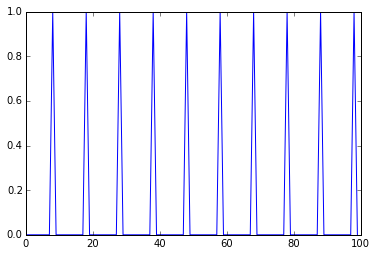

In [27]:
plot(one_every_n(100, 10))

In [55]:
def batch(batch_size, fn, *args):
    X = np.array([fn(*args) for i in range(batch_size)])
    return X[:,:-1,None], X[:,1:,None]

In [427]:
batch(10, one_every_n, 10, 2)[0].shape

(10, 9, 1)

In [282]:
import random

In [273]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import TimeDistributedDense

In [331]:
def random_sample():
    return {
        'learning_rate': random.uniform(0.1, 1),
        'recurrent_layer': random.choice([LSTM, GRU, SimpleRNN]),
        'activation': random.choice(['sigmoid', 'tanh']),
        'every_n': random.randint(2, 20),
        'n_hidden': random.randint(1, 20),
        'n_layers': random.randint(2, 4),
        'tdd_in': random.choice([True, False]),
        'tdd_out': random.choice([True, False]),
    }

In [424]:
def build_model(learning_rate=None, recurrent_layer=None, n_hidden=None, n_layers=None, tdd_in=None, tdd_out=None, activation=None, **kwargs):
    model = Sequential()

    if tdd_in:
        model.add(TimeDistributedDense(input_dim=1, output_dim=n_hidden))
    else:
        model.add(recurrent_layer(input_dim=1, output_dim=n_hidden, activation=activation, return_sequences=True))

    for i in range(n_layers - 2):
        model.add(recurrent_layer(input_dim=n_hidden, output_dim=n_hidden, activation=activation, return_sequences=True))

    if tdd_out:
        model.add(TimeDistributedDense(input_dim=n_hidden, output_dim=1))
    else:
        model.add(recurrent_layer(input_dim=n_hidden, output_dim=1, activation=activation, return_sequences=True))

    # sgd = SGD(lr=learning_rate)
    
    # model.compile(loss='mean_squared_error', optimizer=sgd)
    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    return model

In [333]:
BATCH_SIZE = 1024*128
LENGTH = 128

In [349]:
8*60/3.

160.0

In [431]:
params = {
    'learning_rate': 0.1,
    'recurrent_layer': SimpleRNN,
    'activation': 'tanh',
    'every_n': 20,
    'n_hidden': 1024,
    'n_layers': 4,
    'tdd_in': False,
    'tdd_out': False,
}

In [433]:
from IPython.display import clear_output
import json

# for i in range(1000):
for i in [1]:
    # build model
    # params = random_sample()
    model = build_model(**params)

    # make training data
    X, Y = batch(BATCH_SIZE, one_every_n, LENGTH, params['every_n'])

    # train model
    history = model.fit(X, Y, nb_epoch=1, batch_size=128)

    # log to file one line per model, data represented by json
    params['loss'] = history.history['loss'][0]
    params['recurrent_layer'] = params['recurrent_layer'].__name__
    with open('log', 'a') as f:
        f.write(json.dumps(params))
    
    clear_output()

In [429]:
# predict one example
X, Y = batch(1, one_every_n, LENGTH, params['every_n'])
Y_out = model.predict(X)

0.237076640657


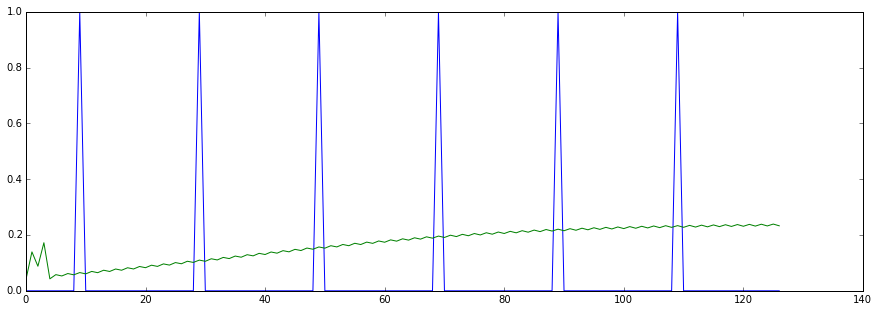

In [430]:
# plot example
print params['loss']
plot(X[0,:])
# show()
# plot(Y[0,:])
plot(Y_out[0,:])
# show()

In [354]:
with open('log') as f:
    experiments = f.read().split('}{')
    experiments[0] = experiments[0][1:]
    experiments[-1] = experiments[-1][:-1]

In [356]:
experiments = [
    json.loads('{'+e+'}') for e in experiments
]

In [358]:
import pandas as pd

In [412]:
df = pd.DataFrame(experiments)
df = df[df['loss'] < 0.075]

In [413]:
for c in ['activation', 'recurrent_layer']:
    d = {k: v for v, k in enumerate(sorted(list(set(df[c]))))}
    print c, d
    df[c] = [d[e] for e in df[c]]

activation {u'tanh': 1, u'sigmoid': 0}
recurrent_layer {u'LSTM': 1, u'GRU': 0, u'SimpleRNN': 2}


In [414]:
for c in ['n_layers', 'tdd_in', 'tdd_out', 'activation', 'recurrent_layer']:
    df[c] += np.random.random(len(df))*0.2

In [415]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, gridplot, show
from bokeh.io import output_notebook

output_notebook()

# create a column data source for the plots to share
source = ColumnDataSource(data=df)

TOOLS = "box_select,lasso_select,help,box_zoom"

plotss = []
plots = []
for column in df.columns:
    if column == 'loss':
        continue
    
    f = figure(tools=TOOLS, width=300, height=300, title=column)
    f.circle(column, 'loss', source=source)
    plots.append(f)
    if len(plots) == 3:
        plotss.append(plots)
        plots = []

plotss.append(plots)
p = gridplot(plotss)

show(p)

Loading BokehJS ...